In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Load data and transform 

In [9]:
df_raw = pd.read_csv('data/anova/Supabase Snippet Retrieve Valid Session Allocations (1).csv')
df = df_raw.drop(['trial_sequence_id', 'session_id'], axis=1)
df[['part1', 'part2']] = df['scenario_name'].str.split('_', expand=True)
df = df.drop('scenario_name', axis=1)

df

,allocation_fund_a,part1,part2
0,50,long,biased
1,50,long,unbiased
2,30,short,biased
3,10,short,unbiased
4,40,long,biased
...,...,...,...
72,50,short,unbiased
73,50,long,biased
74,30,long,unbiased
75,0,short,biased


## Data Summary

In [10]:
summary = df.groupby(['part1', 'part2'])['allocation_fund_a'].agg(['size', 'mean', 'std']).rename(columns={'size':'count'}).reset_index()
summary['se'] = summary['std'] / np.sqrt(summary['count'])

summary


,part1,part2,count,mean,std,se
0,long,biased,20,38.800000,25.266162,5.649686
1,long,unbiased,19,45.157895,25.364593,5.819037
2,short,biased,19,45.842105,23.807709,5.461863
3,short,unbiased,19,50.263158,19.823785,4.547888


## Distribution analysis

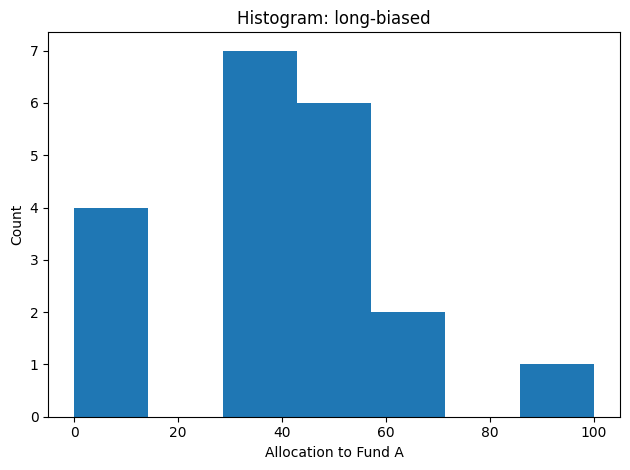

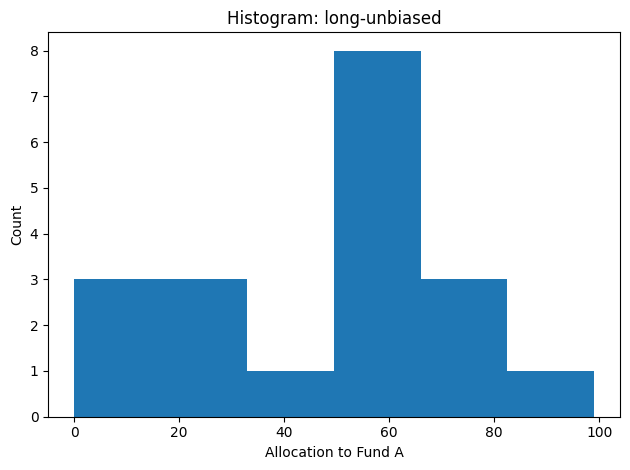

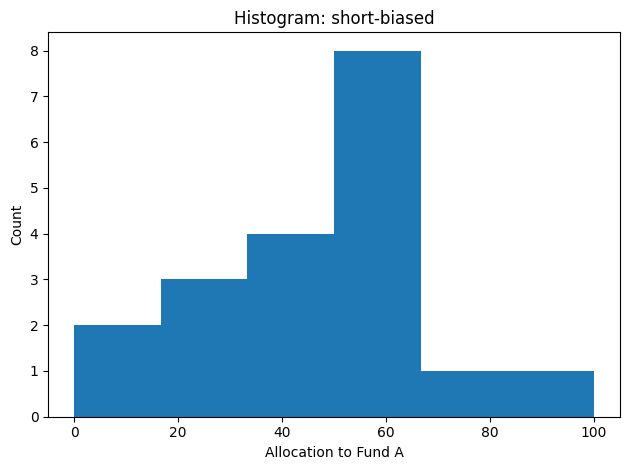

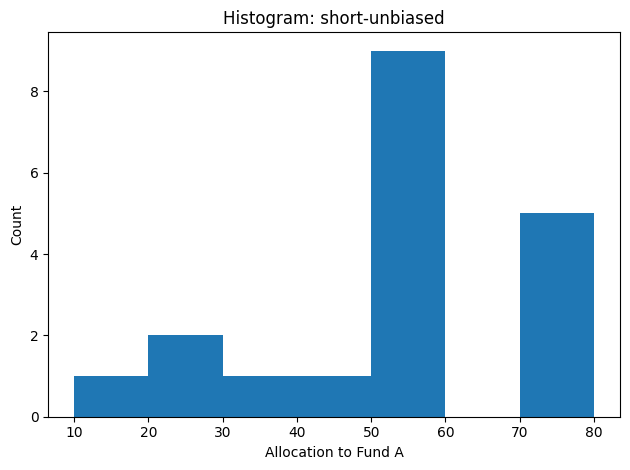

In [7]:
for (p1, p2), group in df.groupby(['part1', 'part2']):
    plt.figure()
    plt.hist(group['allocation_fund_a'], bins='auto')
    plt.xlabel('Allocation to Fund A')
    plt.ylabel('Count')
    plt.title(f'Histogram: {p1}-{p2}')
    plt.tight_layout()
    plt.show()

## Box Plot

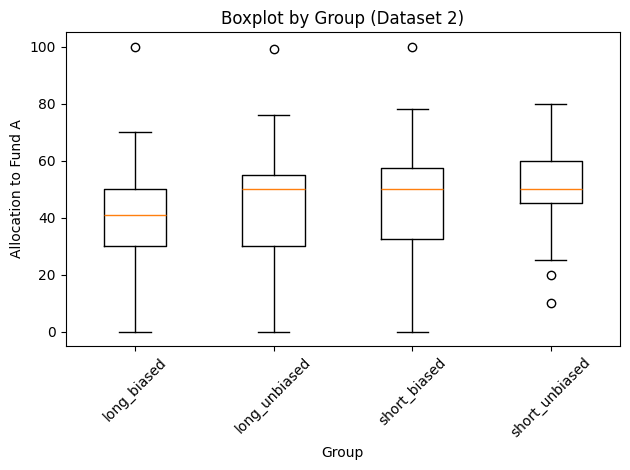

In [11]:
grouped = df.groupby(['part1','part2'])['allocation_fund_a'].apply(list)
labels = [f"{i[0]}_{i[1]}" for i in grouped.index]
plt.figure(); plt.boxplot(grouped.values); plt.xticks(range(1,len(labels)+1), labels, rotation=45)
plt.xlabel('Group'); plt.ylabel('Allocation to Fund A'); plt.title('Boxplot by Group (Dataset 2)'); plt.tight_layout(); plt.show()

## Interaction Plot

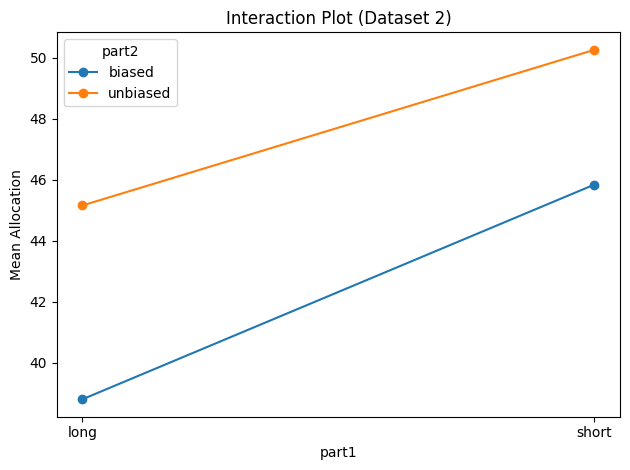

In [12]:
means = df.groupby(['part1','part2'])['allocation_fund_a'].mean().unstack('part2')
plt.figure()
for lvl in means.columns:
    plt.plot(means.index, means[lvl], marker='o', label=lvl)
plt.xlabel('part1'); plt.ylabel('Mean Allocation'); plt.title('Interaction Plot (Dataset 2)'); plt.legend(title='part2'); plt.tight_layout(); plt.show()